**CLASSIFICAZIONE DI IMMAGINI CONTENTENTI DIGIT CON UNA RETE NEURALE CONVOLUZIONALE CUSTOMIZZATA**

In [1]:
### AUTHENTICATION
# Install the PyDrive wrapper 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load weights and model

In [2]:
# Load weights
fileId1 = drive.CreateFile({'id': '1V1AqkX7giXUAH4I6NrdGaZgnWxv6CsfK'}) #DRIVE_FILE_ID
fileId1.GetContentFile(fileId1['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId1['title'], fileId1['id']))

#load model
fileId1 = drive.CreateFile({'id': '1qoM-X-efcN1IqXB_7GqelZXJjRbNDNz-'}) #DRIVE_FILE_ID
fileId1.GetContentFile(fileId1['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId1['title'], fileId1['id']))

Uploaded model_weights.h5, id 1V1AqkX7giXUAH4I6NrdGaZgnWxv6CsfK
Uploaded model.json, id 1qoM-X-efcN1IqXB_7GqelZXJjRbNDNz-


# Import Libraries

In [3]:
# Import libraries 
import numpy as np
import cv2

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.models import model_from_json
from keras.models import load_model

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
from itertools import cycle
from scipy import interp
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

# Image processing

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_classes = 10

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
input_shape = (img_rows, img_cols, 1)
input_shape

(28, 28, 1)

In [6]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


(28, 28)


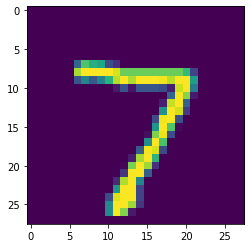

In [8]:
print(x_test[0,:,:,0].shape)
plt.imshow(x_test[0,:,:,0])
plt.show()

In [9]:
print(y_test)
print(np.unique(y_test))

[7 2 1 ... 4 5 6]
[0 1 2 3 4 5 6 7 8 9]


In [10]:
from keras.utils import np_utils

# convert class vectors to binary class matrices

y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [11]:
y_test.shape
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Model summary

In [12]:
json_file = open('model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               1179776   
                                                      

In [13]:
'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
'''

"\nmodel = Sequential()\nmodel.add(Conv2D(32, kernel_size=(3, 3),\n                 activation='relu',\n                 input_shape=input_shape))\nmodel.add(Conv2D(64, (3, 3), activation='relu'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\nmodel.add(Flatten())\nmodel.add(Dense(128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(num_classes, activation='softmax'))\n"

In [14]:
#load weights
model.load_weights('model_weights.h5')

# Prediction

In [15]:
y_score = model.predict(x_test)
print(y_score.shape)

y_pred = np.argmax(y_score, axis = 1) #(10000,)
y_test_ = np.argmax(y_test, axis = 1) #(10000,)

(10000, 10)


# Metrics

In [16]:
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6), dpi=80)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

Confusion matrix, without normalization
Normalized confusion matrix


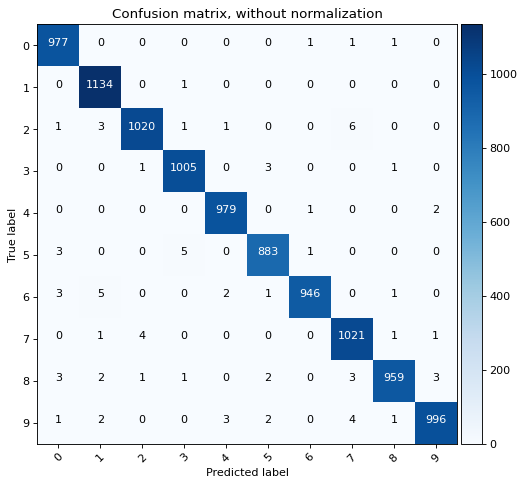

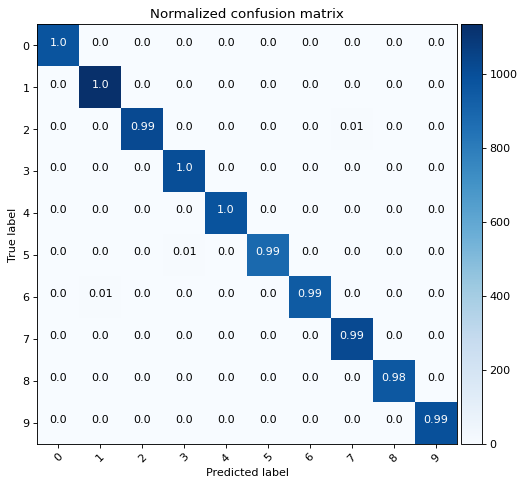

In [18]:
class_names = {0,1,2,3,4,5,6,7,8,9}

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_, y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [19]:
cnf_matrix

array([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
       [   0, 1134,    0,    1,    0,    0,    0,    0,    0,    0],
       [   1,    3, 1020,    1,    1,    0,    0,    6,    0,    0],
       [   0,    0,    1, 1005,    0,    3,    0,    0,    1,    0],
       [   0,    0,    0,    0,  979,    0,    1,    0,    0,    2],
       [   3,    0,    0,    5,    0,  883,    1,    0,    0,    0],
       [   3,    5,    0,    0,    2,    1,  946,    0,    1,    0],
       [   0,    1,    4,    0,    0,    0,    0, 1021,    1,    1],
       [   3,    2,    1,    1,    0,    2,    0,    3,  959,    3],
       [   1,    2,    0,    0,    3,    2,    0,    4,    1,  996]])

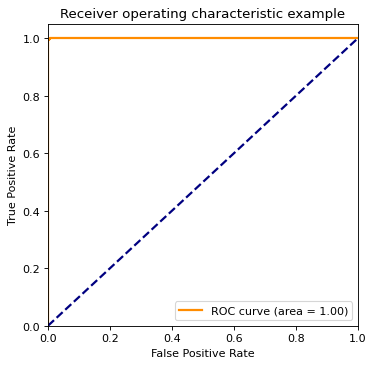

In [24]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(5, 5), dpi=80)
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


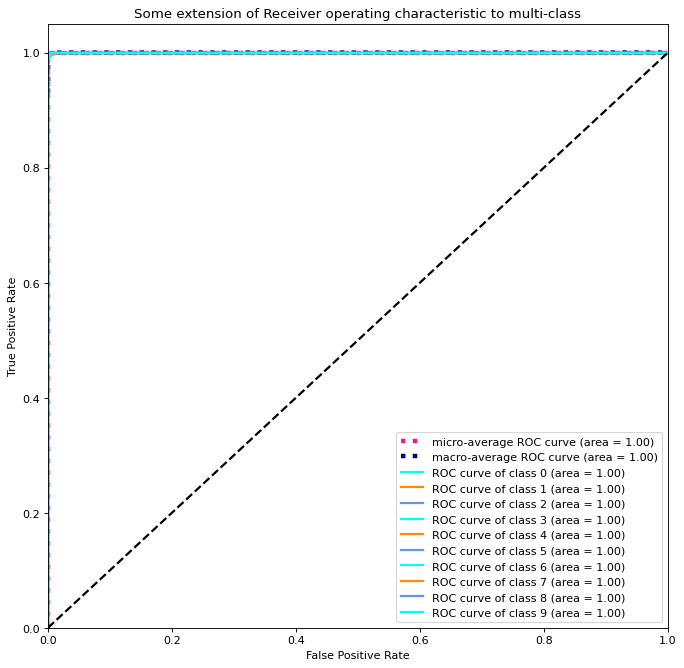

In [25]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()